In [74]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical





In [75]:
def load_labels(base_dir, num_samples=None):
    """Load labels from text files in the specified directory."""
    txt_data = {}
    label_files = [os.path.join(root, file)
                   for root, _, files in os.walk(base_dir)
                   for file in files if file.endswith(".txt")]

    if not label_files:
        print("No label files found.")
        return {}

    selected_label_files = random.sample(label_files, num_samples or len(label_files))

    for file_path in selected_label_files:
        try:
            with open(file_path, 'r') as f:
                txt_data[file_path] = f.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    print(f"Loaded {len(txt_data)} TXT files from {base_dir}")
    return txt_data

def load_images(base_dir, num_samples=None):
    """Load images from the specified directory."""
    image_files = [os.path.join(root, file)
                   for root, _, files in os.walk(base_dir)
                   for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("No image files found.")
        return np.array([]), []

    selected_image_files = random.sample(image_files, num_samples or len(image_files))
    images = []

    for file_path in selected_image_files:
        try:
            image = Image.open(file_path).resize((224, 224)).convert('RGB')
            images.append(np.array(image))
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")

    print(f"Loaded {len(images)} images from {base_dir}")
    return np.array(images), selected_image_files

def parse_labels(txt_data):
    """Parse labels from loaded text data."""
    labels = []
    for _, data in txt_data.items():
        lines = data.splitlines()
        for line in lines:
            values = line.split()
            if len(values) >= 4:
                labels.append([int(values[0]), float(values[1]), float(values[2]), float(values[3])])
    return np.array(labels)


In [76]:
# Define paths
BASE = "Database_Realtime"
IMU = os.path.join(BASE, "IMU")
VISION = os.path.join(BASE, "Vision/Webcam")

# Load data
print("Loading Labels...")
txt_files = load_labels(IMU)

print("Loading Images...")
images, image_paths = load_images(VISION)

if images.size == 0 or not txt_files:
    raise ValueError("No data loaded. Ensure the dataset paths are correct.")

# Parse labels
print("Parsing Labels...")
y_labels = parse_labels(txt_files)

# Normalize and prepare data
X_images = images / 255.0
y_pose = y_labels[:X_images.shape[0], 0]
depth_labels = y_labels[:X_images.shape[0], 1]
y_labels_combined = np.stack((y_pose, depth_labels), axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)



Loading Labels...
Loaded 54 TXT files from Database_Realtime\IMU
Loading Images...
Loaded 4806 images from Database_Realtime\Vision/Webcam
Parsing Labels...
Training set shape: (3075, 224, 224, 3)
Validation set shape: (769, 224, 224, 3)
Test set shape: (962, 224, 224, 3)


In [77]:
def create_lenet_classification(input_shape, num_classes):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_classification(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet_classification(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.0026 - loss: 6.4132 - val_accuracy: 0.0013 - val_loss: 6.3514
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0037 - loss: 6.2746 - val_accuracy: 0.0013 - val_loss: 6.3524
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0014 - loss: 6.2120 - val_accuracy: 0.0013 - val_loss: 6.3835
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0020 - loss: 6.2199 - val_accuracy: 0.0013 - val_loss: 6.3796
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 8.0636e-04 - loss: 6.2098 - val_accuracy: 0.0000e+00 - val_loss: 6.3684
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 5.8480e-04 - loss: 6.2012 - val_accuracy: 0.0000e+00 - val_loss: 6.3790
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0055 - loss: 6.2077 - val_accuracy: 0.0000e+00 - val_loss: 6.3969
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0037 - l

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

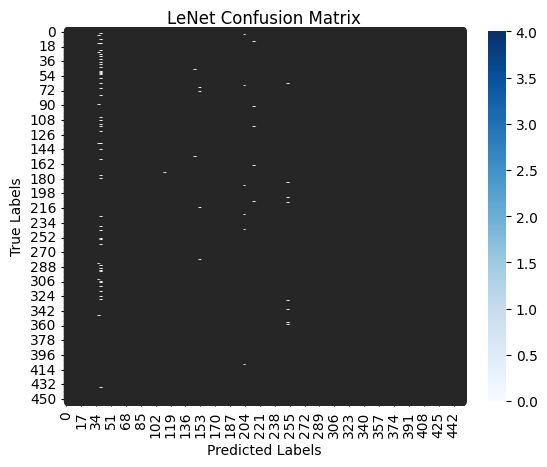

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 65s 331ms/step - accuracy: 0.0022 - loss: 19.2825 - val_accuracy: 0.0013 - val_loss: 6.3735
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 63s 328ms/step - accuracy: 0.0020 - loss: 6.3578 - val_accuracy: 0.0000e+00 - val_loss: 6.3641
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 63s 327ms/step - accuracy: 0.0017 - loss: 6.3435 - val_accuracy: 0.0000e+00 - val_loss: 6.3594
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 63s 329ms/step - accuracy: 0.0016 - loss: 6.3318 - val_accuracy: 0.0013 - val_loss: 6.3556
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - accuracy: 7.1948e-04 - loss: 6.3186 - val_accuracy: 0.0000e+00 - val_loss: 6.3528
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 67s 347ms/step - accuracy: 0.0027 - loss: 6.3126 - val_accuracy: 0.0000e+00 - val_loss: 6.3505
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 64s 333ms/step - accuracy: 0.0018 - loss: 6.3002 - val_accuracy: 0.0000e+00 - val_loss: 6.3488
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 64s 332ms/step - a

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

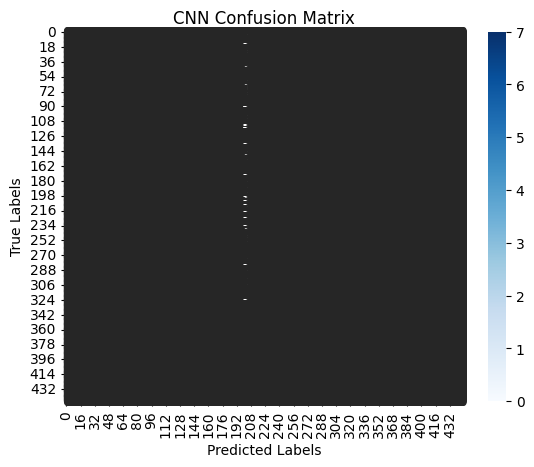

Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.0020 - loss: 6.7191 - val_accuracy: 0.0000e+00 - val_loss: 6.3686
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.0024 - loss: 6.3550 - val_accuracy: 0.0000e+00 - val_loss: 6.3628
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.0033 - loss: 6.3425 - val_accuracy: 0.0000e+00 - val_loss: 6.3580
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.0012 - loss: 6.3291 - val_accuracy: 0.0000e+00 - val_loss: 6.3542
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.0033 - loss: 6.3193 - val_accuracy: 0.0000e+00 - val_loss: 6.3514
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.0023 - loss: 6.3093 - val_accuracy: 0.0000e+00 - val_loss: 6.3493
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.0053 - loss: 6.3012 - val_accuracy: 0.0000e+00 - val_loss: 6.3476
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.00

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

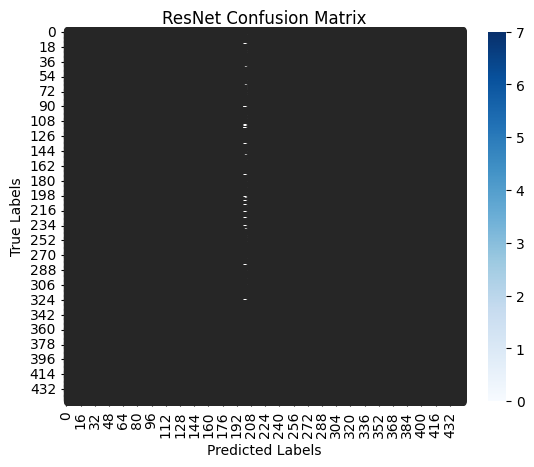

In [78]:

all_labels = np.concatenate((y_train[:, 0], y_val[:, 0], y_test[:, 0]), axis=0)
label_encoder = LabelEncoder()
label_encoder.fit(all_labels.astype('int'))

y_train_classes = label_encoder.transform(y_train[:, 0].astype('int'))
y_val_classes = label_encoder.transform(y_val[:, 0].astype('int'))
y_test_classes = label_encoder.transform(y_test[:, 0].astype('int'))

def train_and_evaluate_classification(model, model_name):
    history = model.fit(X_train, y_train_classes, epochs=10, batch_size=16,
                        validation_data=(X_val, y_val_classes), verbose=1)
    y_pred = model.predict(X_test).argmax(axis=1)
    

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_classes, y_pred))
    cm = confusion_matrix(y_test_classes, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    return history

lenet_model = create_lenet_classification(X_train.shape[1:], len(label_encoder.classes_))
train_and_evaluate_classification(lenet_model, "LeNet")

cnn_model = create_cnn_classification(X_train.shape[1:], len(label_encoder.classes_))
train_and_evaluate_classification(cnn_model, "CNN")

resnet_model_class = create_resnet_classification(X_train.shape[1:], len(label_encoder.classes_))
train_and_evaluate_classification(resnet_model_class, "ResNet")


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE for LeNet Regression: 0.51


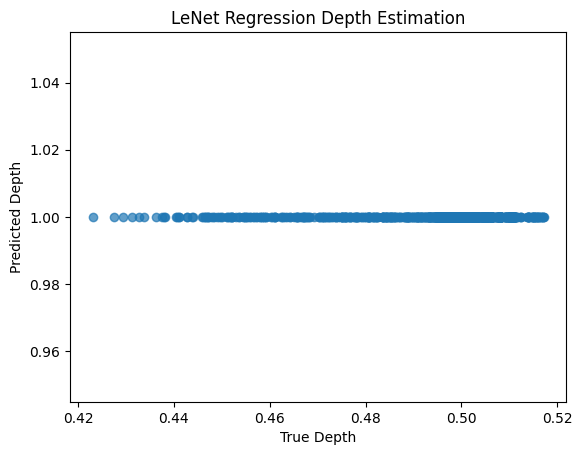

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 63s 324ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 62s 323ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 63s 327ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 64s 330ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_l

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
RMSE for CNN Regression: 0.51


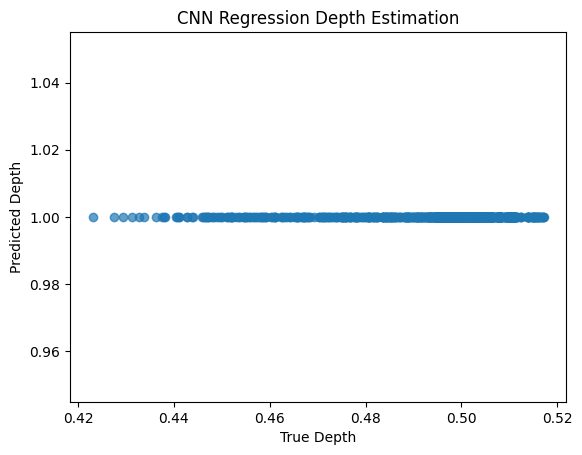

Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 1081s 6s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 874s 5s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000

c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 471ms/step
RMSE for ResNet Regression: 0.51


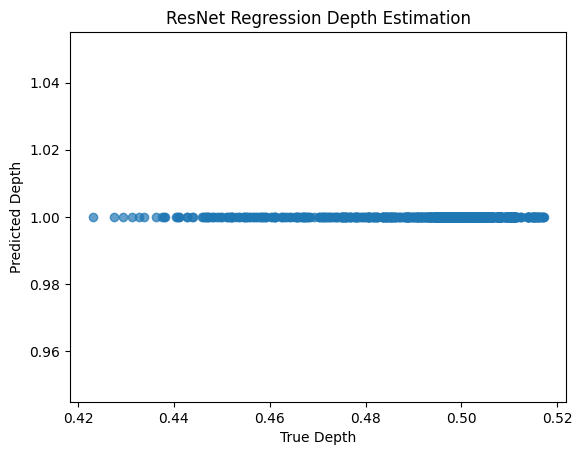

In [79]:
def create_regression_model(input_shape, model_name="cnn"):
    if model_name == "lenet":
        return create_lenet_classification(input_shape, 1)
    elif model_name == "cnn":
        return create_cnn_classification(input_shape, 1)
    elif model_name == "resnet":
        return create_resnet_classification(input_shape, 1)
    else:
        raise ValueError("Invalid model_name")

def train_and_evaluate_regression(model, model_name):
    history = model.fit(X_train, y_train[:, 1], epochs=10, batch_size=16,
                        validation_data=(X_val, y_val[:, 1]), verbose=1)
    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test[:, 1], y_pred))
    print(f"RMSE for {model_name}: {rmse:.2f}")
    

    plt.scatter(y_test[:, 1], y_pred, alpha=0.7)
    plt.xlabel("True Depth")
    plt.ylabel("Predicted Depth")
    plt.title(f"{model_name} Depth Estimation")
    plt.show()
    return history

lenet_reg = create_regression_model(X_train.shape[1:], "lenet")
train_and_evaluate_regression(lenet_reg, "LeNet Regression")

cnn_reg = create_regression_model(X_train.shape[1:], "cnn")
train_and_evaluate_regression(cnn_reg, "CNN Regression")

resnet_reg = create_regression_model(X_train.shape[1:], "resnet")
train_and_evaluate_regression(resnet_reg, "ResNet Regression")
